In [1]:
import time
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from math import pi, sqrt
from numpy import arccos, arctan2
from qiskit.visualization.bloch import Bloch
from qiskit import transpile, assemble, Aer
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_bloch_vector
from qiskit.circuit.library import RYGate, XGate

In [2]:
radius = []
k_list = []
size_list = []

def project(img, n):

    (row, col, _) = img
    x = row
    y = col
    z = 0
    r = round(np.sqrt(2**(2*n)/(8 * np.pi)),4)
    radius.append(r)
    Q = np.array([x, y, z], dtype=np.float32)
    X = get_2d_to_3d(Q,r)
    return X

def get_2d_to_3d(point,r):
    [x, y, _] = point
    k = round(4*r**2 / (x**2 + y**2 + 4*r**2), 4)
    P = np.array([k * x, k * y, (1-2*k)*r ])
    size = np.sqrt(P[0]**2+P[1]**2+P[2]**2)
    resize = P*(1/size)
    k = k * (1/size)
    size_list.append(size)
    k_list.append(k)
    return resize

In [3]:
def generate_coordinates(input_tuple):
    # 입력된 튜플의 값을 2로 나눔
    x, y = input_tuple
    x /= 2
    y /= 2

    # 좌표 리스트 초기화
    coordinates = []

    # 음수부터 양수까지 좌표 생성
    for i in range(-int(x),  int(x) + 1):
        for j in range(-int(x), int(y) + 1):
            if i != 0 and j != 0:
                # z 값은 항상 0
                coordinates.append(np.array([i, j, 0]))
    return coordinates

def generate_normal_coordinates(input_tuple):
    # 입력된 튜플의 값을 2로 나눔
    x, y = input_tuple
    x /= 2
    y /= 2

    # 좌표 리스트 초기화
    coordinates = []

    # 음수부터 양수까지 좌표 생성
    for i in range(-int(x), int(x) + 1):
        for j in range(-int(x), int(y) + 1):
            if i != 0 and j != 0:
                # z 값은 항상 0
                coordinates.append(np.array([i, j, 0]))
    return coordinates

def y_axis_reflection(point):
    return np.array([-point[0], point[1], point[2]])

def x_axis_reflection(point):
    return np.array([point[0], -point[1], point[2]])

def origin_reflection(point):
    return np.array([-point[0], -point[1], point[2]])

In [37]:
def wrap_value(value):
    while value > 300:
        value -= 255
    while value < 0:
        value += 255
    return value

In [4]:
class RGBMapping3D:
    def __init__(self, color_index, color_list):
        self.color_index = np.array(color_index)
        self.color_list = np.array(color_list)

    def plot_points(self):
        fig = plt.figure()
        ax = fig.add_subplot(111)

        # RGB 값에 해당하는 좌표를 점으로 플로팅
        points = np.array([point[0] for point in self.color_list])
        colors = self.color_index / 255
        ax.scatter(x_Q, y_Q, color='black', label = 'Classical')
        ax.scatter(points[:, 0], points[:, 1], c=colors, marker='o', label = 'Recon')
        ax.grid()
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.legend()
        plt.title('Classical and Reconstructed point Comparison')
        plt.show()
        plt.imshow(image)

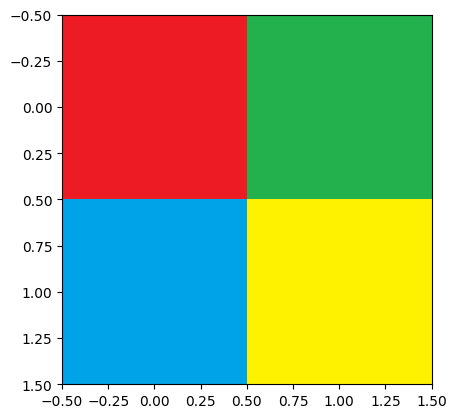

In [4]:
import os
os.path.abspath('')
image = 'pixel2x2.png'
image = os.path.join(os.path.abspath(''),
                            image)
image = np.array(Image.open(image))
plt.imshow(image)

In [143]:
start = time.time()
img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_coordinates(input_tuple)
print(Q)
n = int(np.ceil(math.log(input_tuple[0], 2)))

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

input_im = image.copy().flatten()
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

# red, green, blue, yellow  
color_theta = [np.pi/4,np.pi/4, np.pi/4, np.pi/4]
color_phi = [np.pi/3,0,np.pi/12,np.pi/6] # B,R,Y,G

# Quantum Circuit Implementation
O = QuantumRegister(w_bits+h_bits)
c = QuantumRegister(1)
p = QuantumRegister(1)
color = QuantumRegister(1)
cr = ClassicalRegister(O.size+c.size+p.size+color.size)

qc_image = QuantumCircuit(c,O,p, color,cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)
qc_image.h(color)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 
for i, _ in enumerate(color):
    controls_.extend([color[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.x(O)
qc_image.x(color)
qc_image.barrier()
for i, (phi, theta) in enumerate(zip(color_phi, color_theta)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
    qc_image.barrier()
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()

    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(color)
qc_image.x(p)
qc_image.x(O)
qc_image.barrier()
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

# Measure
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc_image, aer_sim)
qobj = assemble(t_qc, shots=20000)
job_oqim = aer_sim.run(qobj)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()
counts_oqim['11000'] = 0

# Reconstruction
pixel_theta_recon = []
pixel_phi_recon = []

pixel_theta = []
pixel_phi = []

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, len(P)):
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        bin_coord = key[1:3]
        angle_decision = int(key[3])
        switch = int(key[-1]) # switch = 1, position, and switch = 0, color
        int_coord = int(bin_coord, 2)
        if switch == 1:
            if int_coord == i and angle_decision == 1:
                pixel_theta.append((state,bin_coord, amount))
            elif int_coord == i and angle_decision == 0:
                pixel_phi.append((state,bin_coord, amount))
        elif switch == 0:
            if int_coord == i and angle_decision == 1:
                pixel_color_theta.append((state,bin_coord, amount))
            elif int_coord == i and angle_decision == 0:
                pixel_color_phi.append((state,bin_coord, amount))

# position
# ======================== phi ====================================
phi_result_dict = {}
for state in pixel_phi:
    key = state[1]
    value = state[2] 
    if key in phi_result_dict:
        phi_result_dict[key] += value  
    else:
        phi_result_dict[key] = value  

phi_result_list = [(key, value) for key, value in phi_result_dict.items()]
#print(phi_result_list)

phi_state_0 = []
for state, phi, amount in pixel_phi:
    if not int(state):
        phi_state_0.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((phi_state_0[i][1]/phi_result_list[i][1])**(1/2))
        pixel_phi_recon.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
theta_result_dict = {}
for state in pixel_theta:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict:
        theta_result_dict[key] += value  
    else:
        theta_result_dict[key] = value  

theta_result_list = [(key, value) for key, value in theta_result_dict.items()]

theta_state_0 = []

for state, theta, amount in pixel_theta:
    if not int(state):
        theta_state_0.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((theta_state_0[i][1]/theta_result_list[i][1])**(1/2))
        pixel_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

# color
# ======================== phi ====================================
color_phi_result_dict = {}
for state in pixel_color_phi:
    key = state[1]
    value = state[2] 
    if key in color_phi_result_dict:
        color_phi_result_dict[key] += value  
    else:
        color_phi_result_dict[key] = value  

color_phi_result_list = [(key, value) for key, value in color_phi_result_dict.items()]
#print(color_phi_result_list)

color_phi_state_0 = []
for state, phi, amount in pixel_color_phi:
    if not int(state):
        color_phi_state_0.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((color_phi_state_0[i][1]/color_phi_result_list[i][1])**(1/2))
        pixel_color_phi_recon.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
color_theta_result_dict = {}
for state in pixel_color_theta:
    key = state[1]
    value = state[2] 
    if key in color_theta_result_dict:
        color_theta_result_dict[key] += value  
    else:
        color_theta_result_dict[key] = value  

color_theta_result_list = [(key, value) for key, value in color_theta_result_dict.items()]

color_theta_state_0 = []

for state, theta, amount in pixel_color_theta:
    if not int(state):
        color_theta_state_0.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((color_theta_state_0[i][1]/color_theta_result_list[i][1])**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

# theta가 항상 1.57, pi/2 이므로 z = 0 , thus n = 255
# 좌표들의 phi 각도를 보며 유추 할 수 있으므로
# 순서대로 G,Y,R,B

recon_color = []
for i in range(len(pixel_color_phi_recon)):
    n_recon = round(pixel_color_theta_recon[i] * 510 / np.pi,2)
    k_recon = round(pixel_color_phi_recon[i] * 3 * n_recon / np.pi,2)
   
    #while n_recon>300:
        #n_recon -= 255
    
    #while n_recon <0:
        #n_recon += 255    
   
    #while k_recon>300:
        #k_recon -= 255
    
    #while k_recon <0:
        #k_recon += 255


    print(f"{i} th pixel phi, theta angle",pixel_color_phi_recon[i] * 180 / np.pi, pixel_color_theta_recon[i] * 180 / np.pi)

    if pixel_color_phi_recon[i] <= 1.0472:
        recon_color.append(np.array([n_recon,k_recon,0]))
    elif 1.0472 < pixel_color_phi_recon[i] <= 1.0472*2:
        recon_color.append(np.array([n_recon-k_recon,n_recon,0]))
    elif 1.0472*2 < pixel_color_phi_recon[i] <= 1.0472*3:
        recon_color.append(np.array([0,n_recon,k_recon]))
    elif 1.0472*3 < pixel_color_phi_recon[i] <= 1.0472*4:
        recon_color.append(np.array([0,n_recon-k_recon,n_recon]))
    elif 1.0472*4 < pixel_color_phi_recon[i] <= 1.0472*5:
        recon_color.append(np.array([k_recon,0,n_recon]))
    elif 1.0472*5 < pixel_color_phi_recon[i] <= 1.0472*6:
        recon_color.append(np.array([n_recon,0,n_recon-k_recon]))
    
print(recon_color)
recon_color = list(reversed(recon_color))
# Visualization
recon_pixel = []
for i in range(len(P)):
    x = np.cos(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
    y = np.sin(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
    z = np.cos(pixel_theta_recon[i])
    recon_pixel.append(np.array([x,y,z]))
back_recon_pixel = []
for i in range(len(P)):
    k = 0.5 * (1 - recon_pixel[i][2] * size_list[i] / radius[0])
    k = k / size_list[i]
    X = recon_pixel[i][0] / k
    Y = recon_pixel[i][1] / k
    back_P = np.array([X,Y,0])
    back_recon_pixel.append(back_P)


color_list = []
for i in range(len(back_recon_pixel)):
    color_list.append([back_recon_pixel[i]])
print("Reconstructed pixel =",color_list)
x_values = [point[0] for point in back_recon_pixel]
y_values = [point[1] for point in back_recon_pixel]

x_Q = [point[0] for point in Q]
y_Q = [point[1] for point in Q]

end = time.time()
print(f"{end - start:.5f} sec")
error = []
for i in range(len(Q)):
    del_x = x_Q[i] - x_values[i]
    del_y = y_Q[i] - y_values[i]
    err = del_x**2+del_y**2
    error.append(err)
error # a,b,c,d

ME = sum(error)/len(Q)
print("ME =",ME)

[array([-1, -1,  0]), array([-1,  1,  0]), array([ 1, -1,  0]), array([1, 1, 0])]
0 th pixel phi, theta angle 120.58181917899671 90.04458815976362
1 th pixel phi, theta angle 59.31740795957305 87.97737594693389
2 th pixel phi, theta angle 0.0 89.03506956796038
3 th pixel phi, theta angle 239.7340497529378 89.21383469259663
[array([  0.  , 255.13, 512.73]), array([249.27, 246.43,   0.  ]), array([252.27,   0.  ,   0.  ]), array([   0.  , -757.19,  252.77])]
Reconstructed pixel = [[array([1.06566699, 0.92597837, 0.        ])], [array([ 0.95085354, -1.07018288,  0.        ])], [array([-1.09094645,  1.02351652,  0.        ])], [array([-0.93215355, -1.15017512,  0.        ])]]
0.10968 sec
ME = 8.222751493039917


C:\Users\HCI\AppData\Local\Temp\ipykernel_5264\3258139983.py:144: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_oqim = aer_sim.run(qobj)


C:\Users\HCI\AppData\Local\Temp\ipykernel_5264\812477715.py:3: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(color_list_dim[i][0][0],color_list_dim[i][0][1],c=result_array, marker='o')


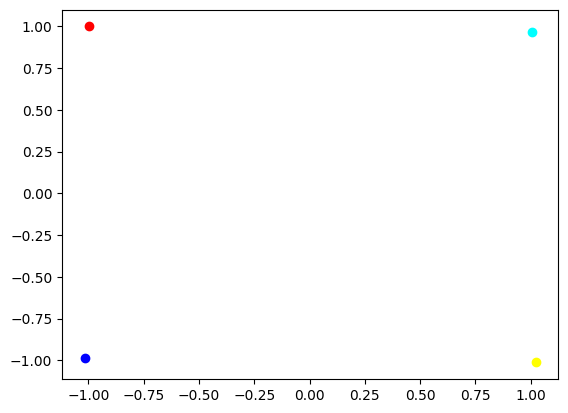

In [144]:
for i in range(len(recon_color)):
    result_array = (recon_color[i] / 255 > 0).astype(int)
    plt.scatter(color_list_dim[i][0][0],color_list_dim[i][0][1],c=result_array, marker='o')
plt.show()

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


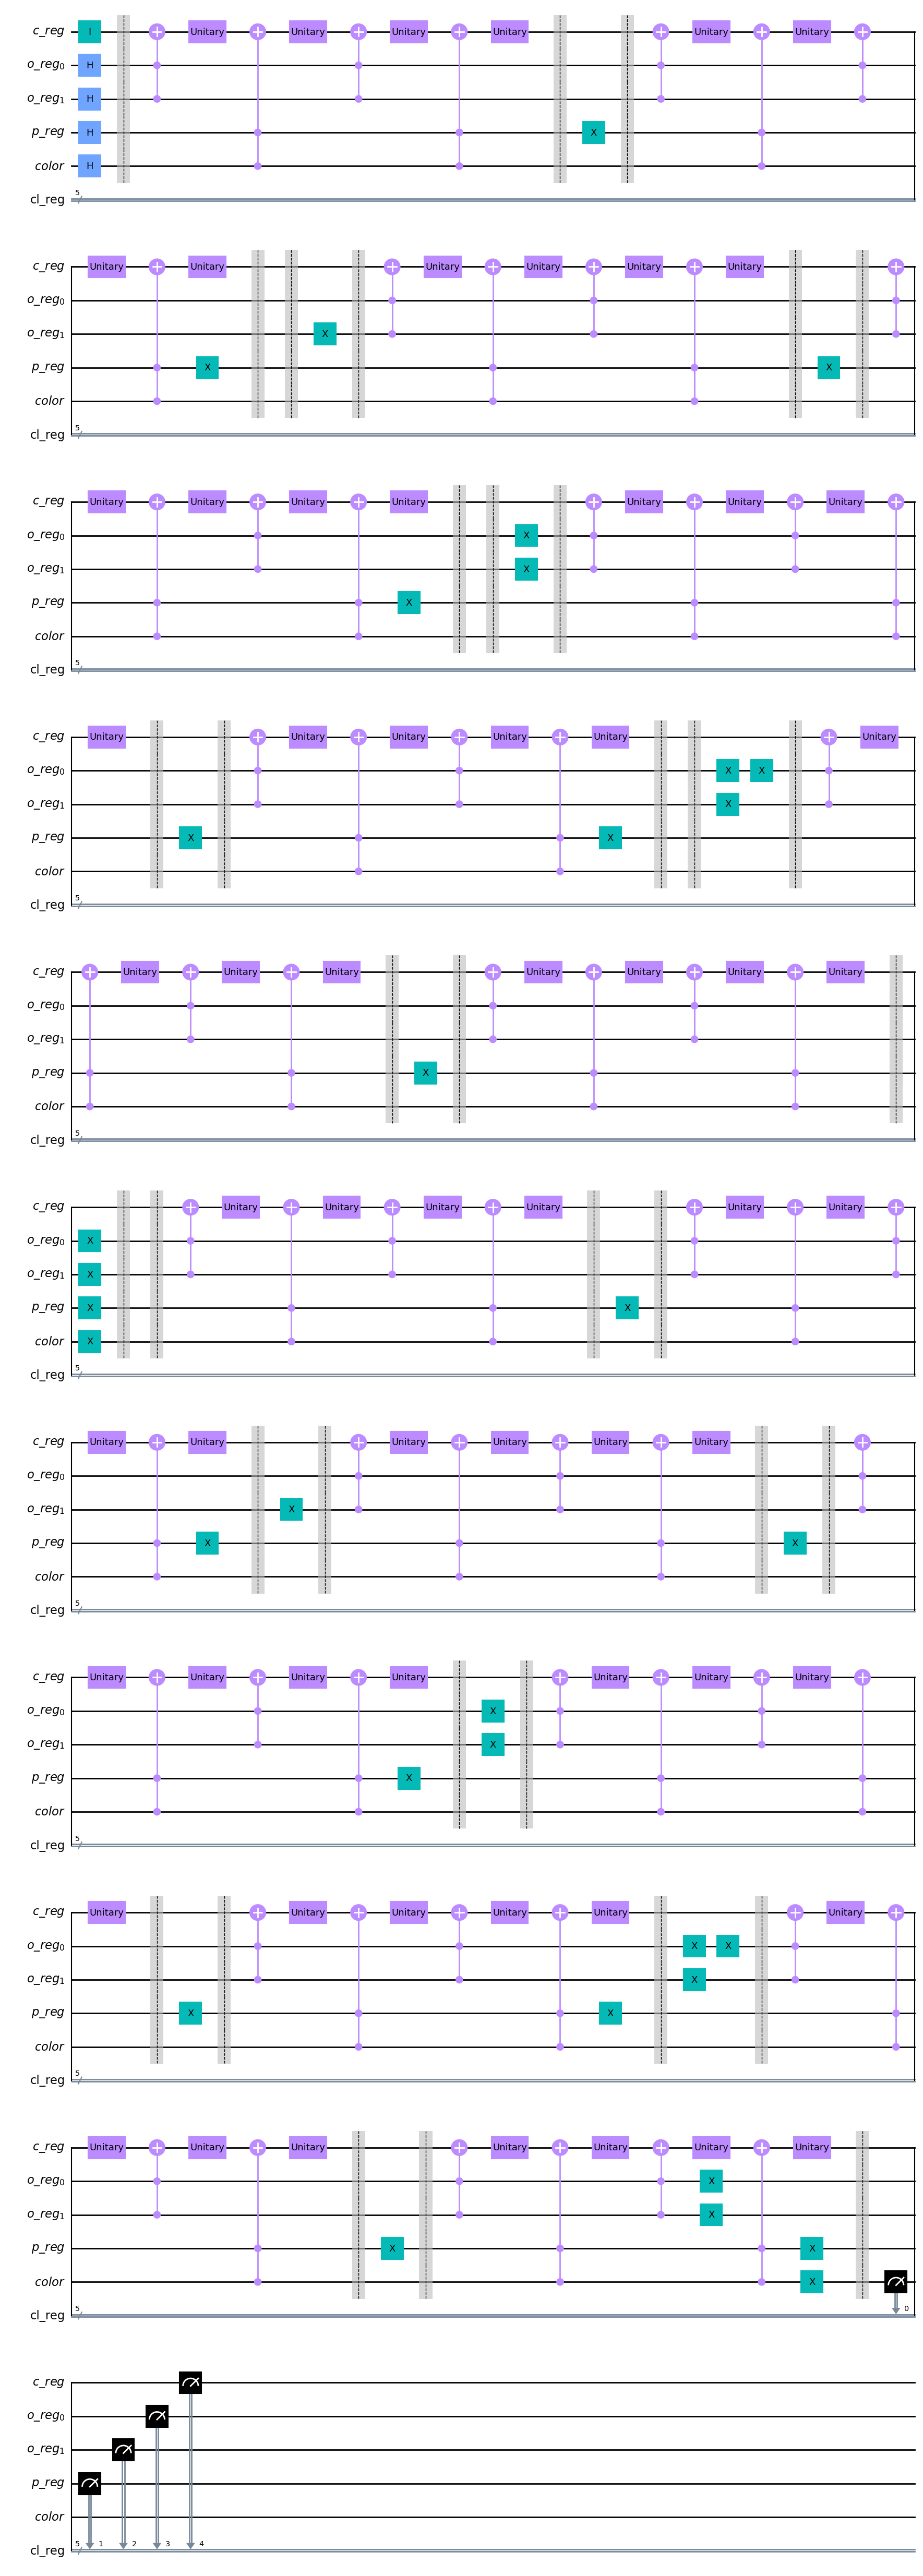

In [277]:
qc_image.draw('mpl')

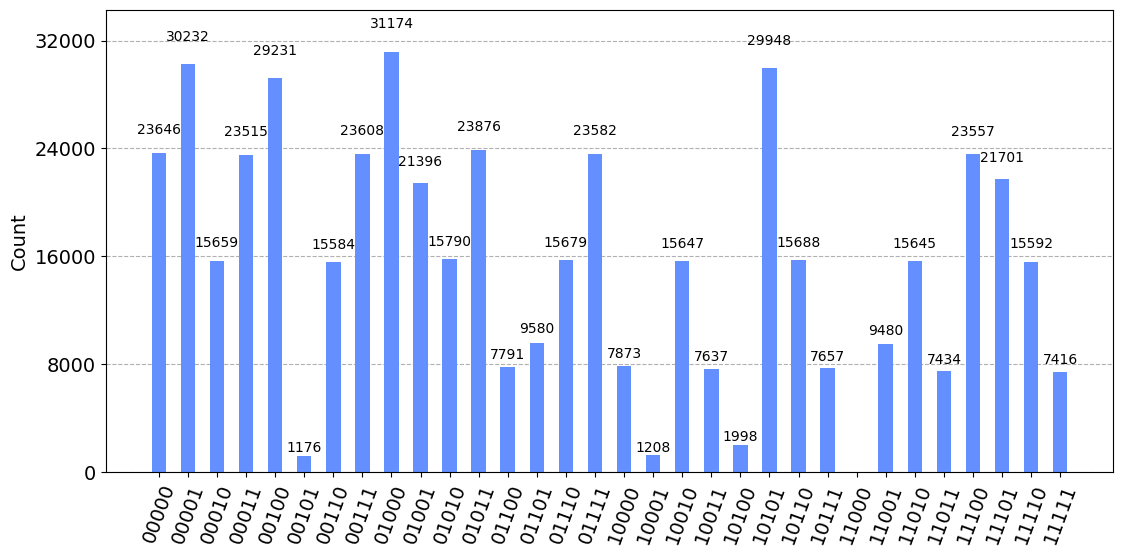

In [281]:
plot_histogram(counts_oqim, figsize=(13,6))

In [252]:
print(pixel_theta,"\n",pixel_phi, "\n",pixel_color_theta, "\n",pixel_color_phi)

[('0', '00', 23767), ('1', '00', 7584), ('1', '01', 7733), ('0', '01', 23879), ('0', '10', 23808), ('1', '10', 7590), ('0', '11', 23457), ('1', '11', 7651)] 
 [('0', '00', 29958), ('1', '00', 1217), ('1', '01', 30187), ('0', '01', 1211), ('0', '10', 21290), ('1', '10', 9726), ('0', '11', 9670), ('1', '11', 21535)] 
 [('0', '00', 15488), ('1', '00', 15721), ('0', '01', 15625), ('1', '01', 15514), ('0', '10', 15667), ('1', '10', 15391), ('1', '11', 15445), ('0', '11', 15475)] 
 [('1', '00', 7743), ('0', '00', 23451), ('0', '01', 29254), ('1', '01', 2109), ('0', '10', 31360), ('1', '10', 0), ('1', '11', 23632), ('0', '11', 7862)]


In [255]:
for i in range(len(pixel_phi_recon)):
    print(f"{i} th pixel phi, theta angle",pixel_phi_recon[i] * 180 / np.pi, pixel_theta_recon[i] * 180 / np.pi)

0 th pixel phi, theta angle 45.58182012271948 58.92312564677795
1 th pixel phi, theta angle 314.69607949466825 59.28583971246156
2 th pixel phi, theta angle 136.21827282664538 58.900241797989466
3 th pixel phi, theta angle 224.69555390550255 59.46259174136931


In [257]:
# theta가 항상 1.57, pi/2 이므로 z = 0 , thus n = 255
# 좌표들의 phi 각도를 보며 유추 할 수 있으므로
# 순서대로 G,Y,R,B
color_index = [[0,255,0],[255,255,0],[255,0,0],[0,0,255]]

In [260]:
x_values = [point[0] for point in back_recon_pixel]
y_values = [point[1] for point in back_recon_pixel]

x_Q = [point[0] for point in Q]
y_Q = [point[1] for point in Q]

error = []
for i in range(len(Q)):
    del_x = x_Q[i] - x_values[i]
    del_y = y_Q[i] - y_values[i]
    err = del_x**2+del_y**2
    error.append(err)
error # a,b,c,d

ME = sum(error)/len(Q)
print("ME =",ME)

[array([-1, -1,  0]), array([-1,  1,  0]), array([ 1, -1,  0]), array([1, 1, 0])] 
 [array([-0.99294813, -0.98245157,  0.        ]), array([-1.02008144,  0.97759862,  0.        ]), array([ 0.98598878, -0.99650484,  0.        ]), array([0.98840829, 1.00868886, 0.        ])]
0.0004202891433000938


# 각 좌표에 color mapping

In [261]:
color_list = []
for i in range(len(back_recon_pixel)):
    color_list.append([back_recon_pixel[i]])

color_list

[[array([-0.99294813, -0.98245157,  0.        ])],
 [array([-1.02008144,  0.97759862,  0.        ])],
 [array([ 0.98598878, -0.99650484,  0.        ])],
 [array([0.98840829, 1.00868886, 0.        ])]]

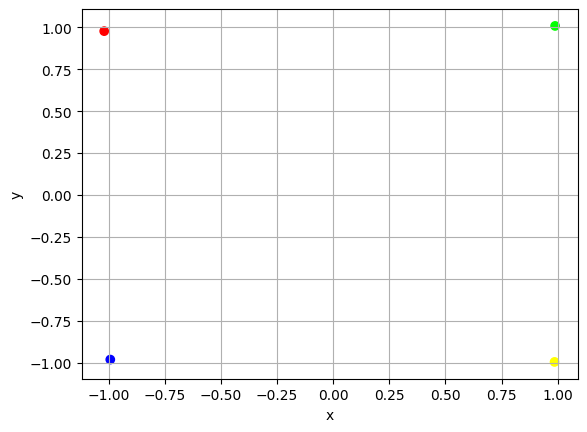

In [267]:
class RGBMapping3D:
    def __init__(self, color_index, color_list):
        self.color_index = np.array(color_index)
        self.color_list = np.array(color_list)

    def plot_points(self):
        fig = plt.figure()
        ax = fig.add_subplot(111)

        # RGB 값에 해당하는 좌표를 점으로 플로팅
        points = np.array([point[0] for point in self.color_list])
        colors = self.color_index / 255
        ax.scatter(x_Q, y_Q, color='black', label = 'Classical')
        ax.scatter(points[:, 0], points[:, 1], c=colors, marker='o', label = 'Recon')
        ax.grid()
        ax.title('Scatter Plot of Points')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.legend()
        plt.show()

rgb_mapping = RGBMapping3D(color_index[:],color_list[:])

# 좌표를 플로팅
rgb_mapping.plot_points()


# IonQ

In [6]:
from qiskit_ionq import IonQProvider
provider = IonQProvider("api")

In [8]:
start = time.time()
img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_coordinates(input_tuple)
print(Q)
n = int(np.ceil(math.log(input_tuple[0], 2)))

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

input_im = image.copy().flatten()
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

# red, green, blue, yellow  
color_theta = [np.pi/4,np.pi/4, np.pi/4, np.pi/4]
color_phi = [4*np.pi/12,0,np.pi/12,2*np.pi/12]

# Quantum Circuit Implementation
O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
color = QuantumRegister(1, "color")
cr = ClassicalRegister(O.size+c.size+p.size+color.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, color,cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)
qc_image.h(color)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 
for i, _ in enumerate(color):
    controls_.extend([color[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.x(O)
qc_image.x(color)
qc_image.barrier()
for i, (phi, theta) in enumerate(zip(color_phi, color_theta)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
    qc_image.barrier()
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()

    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(color)
qc_image.x(p)
qc_image.x(O)
qc_image.barrier()
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

# Measure
ionq_sim = provider.get_backend("ionq_qpu.aria-2")
t_qc_image = transpile(qc_image, ionq_sim)
job_ionq = ionq_sim.run(t_qc_image, shots=1000)
result_ionq = job_ionq.result()
counts_ionq = result_ionq.get_counts()
counts_ionq['11000'] = 0

# Reconstruction
pixel_theta_recon_ionq = []
pixel_phi_recon_ionq = []

pixel_theta_ionq = []
pixel_phi_ionq = []

pixel_color_theta_recon_ionq = []
pixel_color_phi_recon_ionq = []

pixel_color_theta_ionq = []
pixel_color_phi_ionq = []

for i in range(0, len(P)):
    for item in counts_ionq.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        bin_coord = key[1:3]
        angle_decision = int(key[3])
        switch = int(key[-1]) # switch = 1, position, and switch = 0, color
        int_coord = int(bin_coord, 2)
        if switch == 1:
            if int_coord == i and angle_decision == 1:
                pixel_theta_ionq.append((state,bin_coord, amount))
            elif int_coord == i and angle_decision == 0:
                pixel_phi_ionq.append((state,bin_coord, amount))
        elif switch == 0:
            if int_coord == i and angle_decision == 1:
                pixel_color_theta_ionq.append((state,bin_coord, amount))
            elif int_coord == i and angle_decision == 0:
                pixel_color_phi_ionq.append((state,bin_coord, amount))

# position
# ======================== phi ====================================
phi_result_dict_ionq = {}
for state in pixel_phi_ionq:
    key = state[1]
    value = state[2] 
    if key in phi_result_dict_ionq:
        phi_result_dict_ionq[key] += value  
    else:
        phi_result_dict_ionq[key] = value  

phi_result_list_ionq = [(key, value) for key, value in phi_result_dict_ionq.items()]
#print(phi_result_list)

phi_state_0_ionq = []
for state, phi, amount in pixel_phi_ionq:
    if not int(state):
        phi_state_0_ionq.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((phi_state_0_ionq[i][1]/phi_result_list_ionq[i][1])**(1/2))
        pixel_phi_recon_ionq.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
theta_result_dict_ionq = {}
for state in pixel_theta_ionq:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict_ionq:
        theta_result_dict_ionq[key] += value  
    else:
        theta_result_dict_ionq[key] = value  

theta_result_list_ionq = [(key, value) for key, value in theta_result_dict_ionq.items()]

theta_state_0_ionq = []

for state, theta, amount in pixel_theta_ionq:
    if not int(state):
        theta_state_0_ionq.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((theta_state_0_ionq[i][1]/theta_result_list_ionq[i][1])**(1/2))
        pixel_theta_recon_ionq.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

# color
# ======================== phi ====================================
color_phi_result_dict_ionq = {}
for state in pixel_color_phi_ionq:
    key = state[1]
    value = state[2] 
    if key in color_phi_result_dict_ionq:
        color_phi_result_dict_ionq[key] += value  
    else:
        color_phi_result_dict_ionq[key] = value  

color_phi_result_list_ionq = [(key, value) for key, value in color_phi_result_dict_ionq.items()]
#print(color_phi_result_list)

color_phi_state_0_ionq = []
for state, phi, amount in pixel_color_phi_ionq:
    if not int(state):
        color_phi_state_0_ionq.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((color_phi_state_0_ionq[i][1]/color_phi_result_list_ionq[i][1])**(1/2))
        pixel_color_phi_recon_ionq.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
color_theta_result_dict_ionq = {}
for state in pixel_color_theta_ionq:
    key = state[1]
    value = state[2] 
    if key in color_theta_result_dict_ionq:
        color_theta_result_dict_ionq[key] += value  
    else:
        color_theta_result_dict_ionq[key] = value  

color_theta_result_list_ionq = [(key, value) for key, value in color_theta_result_dict_ionq.items()]

color_theta_state_0_ionq = []

for state, theta, amount in pixel_color_theta_ionq:
    if not int(state):
        color_theta_state_0_ionq.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((color_theta_state_0_ionq[i][1]/color_theta_result_list_ionq[i][1])**(1/2))
        pixel_color_theta_recon_ionq.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

# theta가 항상 1.57, pi/2 이므로 z = 0 , thus n = 255
# 좌표들의 phi 각도를 보며 유추 할 수 있으므로
# 순서대로 G,Y,R,B
color_recon_ionq = []
for i in range(len(pixel_color_phi_recon_ionq)):
    color_recon_ionq.append([pixel_color_theta_recon_ionq[i]* 180 / np.pi,pixel_color_phi_recon_ionq[i]* 180 / np.pi,0])
    print(f"{i} th pixel phi, theta angle",pixel_color_phi_recon_ionq[i] * 180 / np.pi, pixel_color_theta_recon_ionq[i] * 180 / np.pi)
color_index = [[0,255,0],[255,255,0],[255,0,0],[0,0,255]]
color_index = list(reversed(color_index))

# Visualization
recon_pixel_ionq = []
for i in range(len(P)):
    x = np.cos(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    y = np.sin(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    z = np.cos(pixel_theta_recon_ionq[i])
    recon_pixel_ionq.append(np.array([x,y,z]))
back_recon_pixel_ionq = []
for i in range(len(P)):
    k = 0.5 * (1 - recon_pixel_ionq[i][2] * size_list[i] / radius[0])
    k = k / size_list[i]
    X = recon_pixel_ionq[i][0] / k
    Y = recon_pixel_ionq[i][1] / k
    back_P = np.array([X,Y,0])
    back_recon_pixel_ionq.append(back_P)
back_recon_pixel_ionq = list(reversed(back_recon_pixel_ionq))

color_list_ionq = []
for i in range(len(back_recon_pixel_ionq)):
    color_list_ionq.append([back_recon_pixel_ionq[i]])
print("Reconstructed pixel =",color_list_ionq)
x_values_ionq = [point[0] for point in back_recon_pixel_ionq]
y_values_ionq = [point[1] for point in back_recon_pixel_ionq]

x_Q = [point[0] for point in Q]
y_Q = [point[1] for point in Q]

end = time.time()
print(f"{end - start:.5f} sec")
error_ionq = []
for i in range(len(Q)):
    del_x = x_Q[i] - x_values_ionq[i]
    del_y = y_Q[i] - y_values_ionq[i]
    err_ionq = np.sqrt(del_x**2+del_y**2)
    error_ionq.append(err_ionq)
error_ionq # a,b,c,d

print("Error =",error_ionq)


[array([-1, -1,  0]), array([-1,  1,  0]), array([ 1, -1,  0]), array([1, 1, 0])]
0 th pixel phi, theta angle 181.94232281797363 90.83040268747908
1 th pixel phi, theta angle 203.073918065631 90.83040268747908
2 th pixel phi, theta angle 0.0 94.91710033552883
3 th pixel phi, theta angle 178.12136570003833 112.61986494804043
Reconstructed pixel = [[array([-0.62617454,  0.10729057,  0.        ])], [array([-0.60688056, -0.59413956,  0.        ])], [array([-8.20905453e-01,  1.00531924e-16,  0.00000000e+00])], [array([-0.43388862, -0.37063474,  0.        ])]]
814.40605 sec
Error = [1.168690669920396, 1.6418964141601697, 2.077425490537147, 1.9836018133057383]


In [293]:
pixel_theta_recon_ionq

[1.565760736813997, 1.5356986164683706, 1.549153733576626, 1.5595780152720635]

In [294]:
pixel_phi_recon_ionq

[3.065938951693834, 3.1893963521744477, 3.1247295839194904, 3.1777828070536676]

In [292]:
color_list_ionq

[[array([-0.80624913, -0.02919102,  0.        ])],
 [array([-0.81511649,  0.01374667,  0.        ])],
 [array([-0.82533587, -0.03948419,  0.        ])],
 [array([-0.79951122,  0.06060164,  0.        ])]]

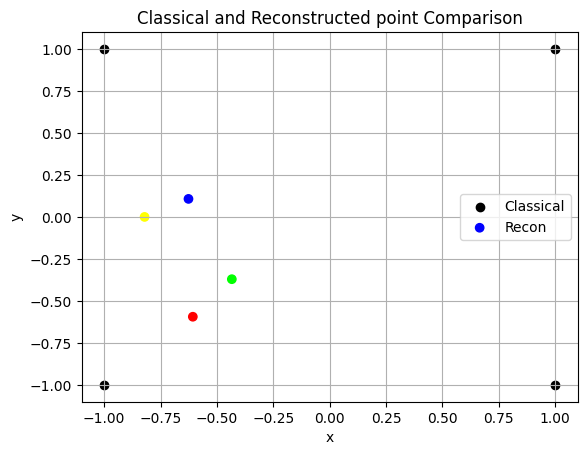

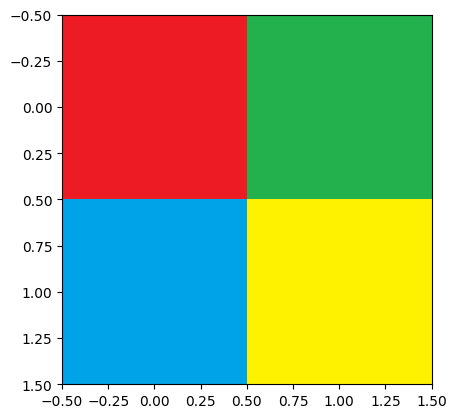

In [9]:
rgb_mapping = RGBMapping3D(color_index[:], color_list_ionq[:])

# 좌표를 플로팅
rgb_mapping.plot_points()

In [10]:
start = time.time()
img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_coordinates(input_tuple)
print(Q)
n = int(np.ceil(math.log(input_tuple[0], 2)))

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

input_im = image.copy().flatten()
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

# red, green, blue, yellow  
color_theta = [np.pi/4,np.pi/4, np.pi/4, np.pi/4]
color_phi = [4*np.pi/12,0,np.pi/12,2*np.pi/12]

# Quantum Circuit Implementation
O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
color = QuantumRegister(1, "color")
cr = ClassicalRegister(O.size+c.size+p.size+color.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, color,cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)
qc_image.h(color)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 
for i, _ in enumerate(color):
    controls_.extend([color[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.x(O)
qc_image.x(color)
qc_image.barrier()
for i, (phi, theta) in enumerate(zip(color_phi, color_theta)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
    qc_image.barrier()
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()

    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(color)
qc_image.x(p)
qc_image.x(O)
qc_image.barrier()
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

# Measure
ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc_image, ionq_sim)
job_ionq = ionq_sim.run(t_qc_image, shots=1000)
result_ionq = job_ionq.result()
counts_ionq = result_ionq.get_counts()
counts_ionq['11000'] = 0

# Reconstruction
pixel_theta_recon_ionq = []
pixel_phi_recon_ionq = []

pixel_theta_ionq = []
pixel_phi_ionq = []

pixel_color_theta_recon_ionq = []
pixel_color_phi_recon_ionq = []

pixel_color_theta_ionq = []
pixel_color_phi_ionq = []

for i in range(0, len(P)):
    for item in counts_ionq.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        bin_coord = key[1:3]
        angle_decision = int(key[3])
        switch = int(key[-1]) # switch = 1, position, and switch = 0, color
        int_coord = int(bin_coord, 2)
        if switch == 1:
            if int_coord == i and angle_decision == 1:
                pixel_theta_ionq.append((state,bin_coord, amount))
            elif int_coord == i and angle_decision == 0:
                pixel_phi_ionq.append((state,bin_coord, amount))
        elif switch == 0:
            if int_coord == i and angle_decision == 1:
                pixel_color_theta_ionq.append((state,bin_coord, amount))
            elif int_coord == i and angle_decision == 0:
                pixel_color_phi_ionq.append((state,bin_coord, amount))

# position
# ======================== phi ====================================
phi_result_dict_ionq = {}
for state in pixel_phi_ionq:
    key = state[1]
    value = state[2] 
    if key in phi_result_dict_ionq:
        phi_result_dict_ionq[key] += value  
    else:
        phi_result_dict_ionq[key] = value  

phi_result_list_ionq = [(key, value) for key, value in phi_result_dict_ionq.items()]
#print(phi_result_list)

phi_state_0_ionq = []
for state, phi, amount in pixel_phi_ionq:
    if not int(state):
        phi_state_0_ionq.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((phi_state_0_ionq[i][1]/phi_result_list_ionq[i][1])**(1/2))
        pixel_phi_recon_ionq.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
theta_result_dict_ionq = {}
for state in pixel_theta_ionq:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict_ionq:
        theta_result_dict_ionq[key] += value  
    else:
        theta_result_dict_ionq[key] = value  

theta_result_list_ionq = [(key, value) for key, value in theta_result_dict_ionq.items()]

theta_state_0_ionq = []

for state, theta, amount in pixel_theta_ionq:
    if not int(state):
        theta_state_0_ionq.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((theta_state_0_ionq[i][1]/theta_result_list_ionq[i][1])**(1/2))
        pixel_theta_recon_ionq.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

# color
# ======================== phi ====================================
color_phi_result_dict_ionq = {}
for state in pixel_color_phi_ionq:
    key = state[1]
    value = state[2] 
    if key in color_phi_result_dict_ionq:
        color_phi_result_dict_ionq[key] += value  
    else:
        color_phi_result_dict_ionq[key] = value  

color_phi_result_list_ionq = [(key, value) for key, value in color_phi_result_dict_ionq.items()]
#print(color_phi_result_list)

color_phi_state_0_ionq = []
for state, phi, amount in pixel_color_phi_ionq:
    if not int(state):
        color_phi_state_0_ionq.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((color_phi_state_0_ionq[i][1]/color_phi_result_list_ionq[i][1])**(1/2))
        pixel_color_phi_recon_ionq.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
color_theta_result_dict_ionq = {}
for state in pixel_color_theta_ionq:
    key = state[1]
    value = state[2] 
    if key in color_theta_result_dict_ionq:
        color_theta_result_dict_ionq[key] += value  
    else:
        color_theta_result_dict_ionq[key] = value  

color_theta_result_list_ionq = [(key, value) for key, value in color_theta_result_dict_ionq.items()]

color_theta_state_0_ionq = []

for state, theta, amount in pixel_color_theta_ionq:
    if not int(state):
        color_theta_state_0_ionq.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((color_theta_state_0_ionq[i][1]/color_theta_result_list_ionq[i][1])**(1/2))
        pixel_color_theta_recon_ionq.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

# theta가 항상 1.57, pi/2 이므로 z = 0 , thus n = 255
# 좌표들의 phi 각도를 보며 유추 할 수 있으므로
# 순서대로 G,Y,R,B
color_recon_ionq = []
for i in range(len(pixel_color_phi_recon_ionq)):
    color_recon_ionq.append([pixel_color_theta_recon_ionq[i]* 180 / np.pi,pixel_color_phi_recon_ionq[i]* 180 / np.pi,0])
    print(f"{i} th pixel phi, theta angle",pixel_color_phi_recon_ionq[i] * 180 / np.pi, pixel_color_theta_recon_ionq[i] * 180 / np.pi)
color_index = [[0,255,0],[255,255,0],[255,0,0],[0,0,255]]
color_index = list(reversed(color_index))

# Visualization
recon_pixel_ionq = []
for i in range(len(P)):
    x = np.cos(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    y = np.sin(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    z = np.cos(pixel_theta_recon_ionq[i])
    recon_pixel_ionq.append(np.array([x,y,z]))
back_recon_pixel_ionq = []
for i in range(len(P)):
    k = 0.5 * (1 - recon_pixel_ionq[i][2] * size_list[i] / radius[0])
    k = k / size_list[i]
    X = recon_pixel_ionq[i][0] / k
    Y = recon_pixel_ionq[i][1] / k
    back_P = np.array([X,Y,0])
    back_recon_pixel_ionq.append(back_P)
back_recon_pixel_ionq = list(reversed(back_recon_pixel_ionq))

color_list_ionq = []
for i in range(len(back_recon_pixel_ionq)):
    color_list_ionq.append([back_recon_pixel_ionq[i]])
print("Reconstructed pixel =",color_list_ionq)
x_values_ionq = [point[0] for point in back_recon_pixel_ionq]
y_values_ionq = [point[1] for point in back_recon_pixel_ionq]

x_Q = [point[0] for point in Q]
y_Q = [point[1] for point in Q]

end = time.time()
print(f"{end - start:.5f} sec")
error_ionq = []
for i in range(len(Q)):
    del_x = x_Q[i] - x_values_ionq[i]
    del_y = y_Q[i] - y_values_ionq[i]
    err_ionq = np.sqrt(del_x**2+del_y**2)
    error_ionq.append(err_ionq)
error_ionq # a,b,c,d

print("Error =",error_ionq)


[array([-1, -1,  0]), array([-1,  1,  0]), array([ 1, -1,  0]), array([1, 1, 0])]
0 th pixel phi, theta angle 127.7922377253202 90.93931714998082
1 th pixel phi, theta angle 79.88901037962978 71.73376857958094
2 th pixel phi, theta angle 0.0 78.14243285054681
3 th pixel phi, theta angle 247.0414807919953 95.21590857045413
Reconstructed pixel = [[array([-0.67475887, -1.24899862,  0.        ])], [array([-0.88462627,  1.22077914,  0.        ])], [array([ 0.66383873, -1.248785  ,  0.        ])], [array([0.95131952, 0.81908086, 0.        ])]]
8.52305 sec
Error = [0.40961213703483756, 0.24910746131547415, 0.41820853029044697, 0.187354008289193]


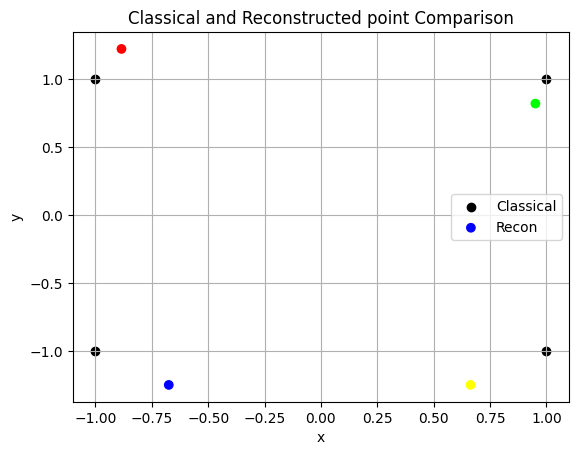

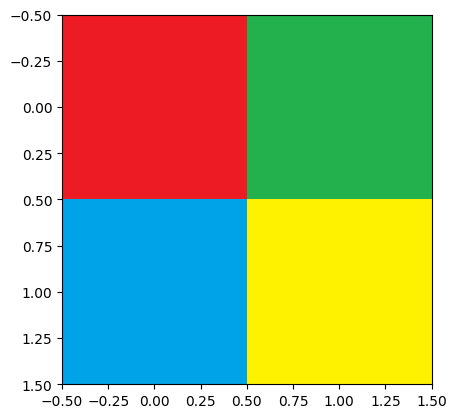

In [11]:
rgb_mapping = RGBMapping3D(color_index[:], color_list_ionq[:])

# 좌표를 플로팅
rgb_mapping.plot_points()

In [290]:
print(provider.backends())

[<IonQSimulatorBackend('ionq_simulator')>, <IonQQPUBackend('ionq_qpu')>]


In [3]:
start = time.time()
img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_coordinates(input_tuple)
print(Q)
n = int(np.ceil(math.log(input_tuple[0], 2)))

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

input_im = image.copy().flatten()
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

# red, green, blue, yellow  
color_theta = [np.pi/4,np.pi/4, np.pi/4, np.pi/4]
color_phi = [4*np.pi/12,0,np.pi/12,2*np.pi/12]

# Quantum Circuit Implementation
O = QuantumRegister(w_bits+h_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
color = QuantumRegister(1, "color")
cr = ClassicalRegister(O.size+c.size+p.size+color.size, "cl_reg")

qc_image = QuantumCircuit(c,O,p, color,cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)
qc_image.h(color)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 
for i, _ in enumerate(color):
    controls_.extend([color[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(p)
qc_image.x(O)
qc_image.x(color)
qc_image.barrier()
for i, (phi, theta) in enumerate(zip(color_phi, color_theta)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
    qc_image.barrier()
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
                qc_image.barrier()

    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(color)
qc_image.x(p)
qc_image.x(O)
qc_image.barrier()
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

# Measure
ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc_image, ionq_sim)
job_ionq = ionq_sim.run(t_qc_image, shots=200000)
result_ionq = job_ionq.result()
counts_ionq = result_ionq.get_counts()
counts_ionq['11000'] = 0

# Reconstruction
pixel_theta_recon_ionq = []
pixel_phi_recon_ionq = []

pixel_theta_ionq = []
pixel_phi_ionq = []

pixel_color_theta_recon_ionq = []
pixel_color_phi_recon_ionq = []

pixel_color_theta_ionq = []
pixel_color_phi_ionq = []

for i in range(0, len(P)):
    for item in counts_ionq.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        bin_coord = key[1:3]
        angle_decision = int(key[3])
        switch = int(key[-1]) # switch = 1, position, and switch = 0, color
        int_coord = int(bin_coord, 2)
        if switch == 1:
            if int_coord == i and angle_decision == 1:
                pixel_theta_ionq.append((state,bin_coord, amount))
            elif int_coord == i and angle_decision == 0:
                pixel_phi_ionq.append((state,bin_coord, amount))
        elif switch == 0:
            if int_coord == i and angle_decision == 1:
                pixel_color_theta_ionq.append((state,bin_coord, amount))
            elif int_coord == i and angle_decision == 0:
                pixel_color_phi_ionq.append((state,bin_coord, amount))

# position
# ======================== phi ====================================
phi_result_dict_ionq = {}
for state in pixel_phi_ionq:
    key = state[1]
    value = state[2] 
    if key in phi_result_dict_ionq:
        phi_result_dict_ionq[key] += value  
    else:
        phi_result_dict_ionq[key] = value  

phi_result_list_ionq = [(key, value) for key, value in phi_result_dict_ionq.items()]
#print(phi_result_list)

phi_state_0_ionq = []
for state, phi, amount in pixel_phi_ionq:
    if not int(state):
        phi_state_0_ionq.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((phi_state_0_ionq[i][1]/phi_result_list_ionq[i][1])**(1/2))
        pixel_phi_recon_ionq.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
theta_result_dict_ionq = {}
for state in pixel_theta_ionq:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict_ionq:
        theta_result_dict_ionq[key] += value  
    else:
        theta_result_dict_ionq[key] = value  

theta_result_list_ionq = [(key, value) for key, value in theta_result_dict_ionq.items()]

theta_state_0_ionq = []

for state, theta, amount in pixel_theta_ionq:
    if not int(state):
        theta_state_0_ionq.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((theta_state_0_ionq[i][1]/theta_result_list_ionq[i][1])**(1/2))
        pixel_theta_recon_ionq.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

# color
# ======================== phi ====================================
color_phi_result_dict_ionq = {}
for state in pixel_color_phi_ionq:
    key = state[1]
    value = state[2] 
    if key in color_phi_result_dict_ionq:
        color_phi_result_dict_ionq[key] += value  
    else:
        color_phi_result_dict_ionq[key] = value  

color_phi_result_list_ionq = [(key, value) for key, value in color_phi_result_dict_ionq.items()]
#print(color_phi_result_list)

color_phi_state_0_ionq = []
for state, phi, amount in pixel_color_phi_ionq:
    if not int(state):
        color_phi_state_0_ionq.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((color_phi_state_0_ionq[i][1]/color_phi_result_list_ionq[i][1])**(1/2))
        pixel_color_phi_recon_ionq.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
color_theta_result_dict_ionq = {}
for state in pixel_color_theta_ionq:
    key = state[1]
    value = state[2] 
    if key in color_theta_result_dict_ionq:
        color_theta_result_dict_ionq[key] += value  
    else:
        color_theta_result_dict_ionq[key] = value  

color_theta_result_list_ionq = [(key, value) for key, value in color_theta_result_dict_ionq.items()]

color_theta_state_0_ionq = []

for state, theta, amount in pixel_color_theta_ionq:
    if not int(state):
        color_theta_state_0_ionq.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((color_theta_state_0_ionq[i][1]/color_theta_result_list_ionq[i][1])**(1/2))
        pixel_color_theta_recon_ionq.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

# theta가 항상 1.57, pi/2 이므로 z = 0 , thus n = 255
# 좌표들의 phi 각도를 보며 유추 할 수 있으므로
# 순서대로 G,Y,R,B
color_recon_ionq = []
for i in range(len(pixel_color_phi_recon_ionq)):
    color_recon_ionq.append([pixel_color_theta_recon_ionq[i]* 180 / np.pi,pixel_color_phi_recon_ionq[i]* 180 / np.pi,0])
    print(f"{i} th pixel phi, theta angle",pixel_color_phi_recon_ionq[i] * 180 / np.pi, pixel_color_theta_recon_ionq[i] * 180 / np.pi)
color_index = [[0,255,0],[255,255,0],[255,0,0],[0,0,255]]
color_index = list(reversed(color_index))

# Visualization
recon_pixel_ionq = []
for i in range(len(P)):
    x = np.cos(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    y = np.sin(pixel_phi_recon_ionq[i]) * np.sin(pixel_theta_recon_ionq[i])
    z = np.cos(pixel_theta_recon_ionq[i])
    recon_pixel_ionq.append(np.array([x,y,z]))
back_recon_pixel_ionq = []
for i in range(len(P)):
    k = 0.5 * (1 - recon_pixel_ionq[i][2] * size_list[i] / radius[0])
    k = k / size_list[i]
    X = recon_pixel_ionq[i][0] / k
    Y = recon_pixel_ionq[i][1] / k
    back_P = np.array([X,Y,0])
    back_recon_pixel_ionq.append(back_P)
back_recon_pixel_ionq = list(reversed(back_recon_pixel_ionq))

color_list_ionq = []
for i in range(len(back_recon_pixel_ionq)):
    color_list_ionq.append([back_recon_pixel_ionq[i]])
print("Reconstructed pixel =",color_list_ionq)
x_values_ionq = [point[0] for point in back_recon_pixel_ionq]
y_values_ionq = [point[1] for point in back_recon_pixel_ionq]

x_Q = [point[0] for point in Q]
y_Q = [point[1] for point in Q]

end = time.time()
print(f"{end - start:.5f} sec")
error_ionq = []
for i in range(len(Q)):
    del_x = x_Q[i] - x_values_ionq[i]
    del_y = y_Q[i] - y_values_ionq[i]
    err_ionq = np.sqrt(del_x**2+del_y**2)
    error_ionq.append(err_ionq)
error_ionq # a,b,c,d

print("Error =",error_ionq)


NameError: name 'image' is not defined

In [ ]:
color_index = [[0,255,0],[255,255,0],[255,0,0],[0,0,255]]
color_index = list(reversed(color_index))

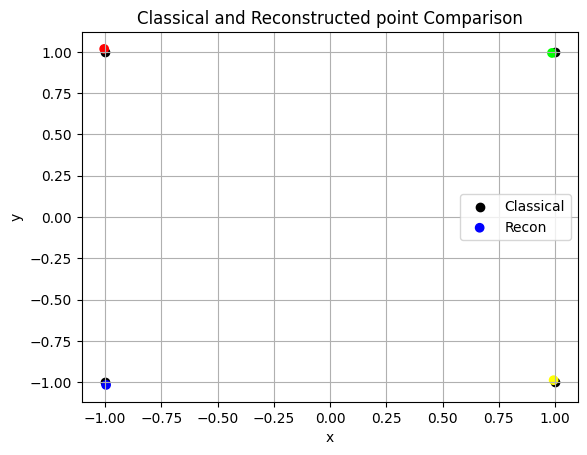

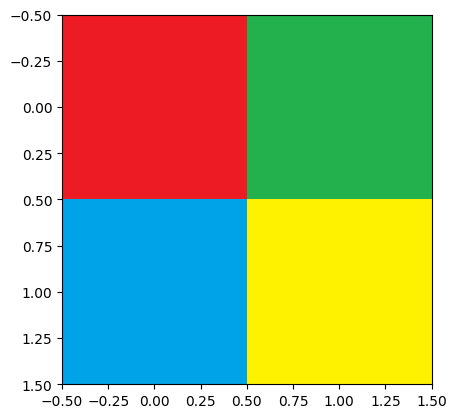

In [298]:
rgb_mapping = RGBMapping3D(color_index[:], color_list[:])

# 좌표를 플로팅
rgb_mapping.plot_points()

In [15]:
2 *0.3435 * 1020 /np.pi

223.0524696444295